In [1]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics.classification import ConfusionMatrix,F1Score
import unicodedata
import spacy
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/natedrake7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/natedrake7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Pre-Processing

In [ ]:
#Read csv files
train_set = pd.read_csv('./Data/train_set.csv')
valid_set = pd.read_csv('./Data/valid_set.csv')
test_set = pd.read_csv('./Data/test_set.csv')



#Drop Party and New ID columns since we dont need them
labels_to_drop = ['Party','New_ID']
train_set = train_set.drop(columns=labels_to_drop)
valid_set = valid_set.drop(columns=labels_to_drop)
test_set = test_set.drop(columns=['Party'])

#Make all text lowercase
train_set['Text'] = train_set['Text'].str.lower()
valid_set['Text'] = valid_set['Text'].str.lower()
test_set['Text'] = test_set['Text'].str.lower()

train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'#', '', x))
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub(r'#', '', x))
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'#', '', x))

#Remove accents from all text
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

train_set['Text'] = train_set['Text'].apply(remove_accents)
valid_set['Text'] = valid_set['Text'].apply(remove_accents)
test_set['Text'] = test_set['Text'].apply(remove_accents)

#Remove stopwords and replace them with a single space
stop = stopwords.words('greek')
pat = r'\b(?:{})\b'.format('|'.join(stop))

train_set['Text'] = train_set['Text'].str.replace(pat,'',regex=True)
valid_set['Text'] = valid_set['Text'].str.replace(pat,'',regex=True)
test_set['Text'] = test_set['Text'].str.replace(pat,'',regex=True)

#Remove multiple white spaces and replace them with a single space
train_set['Text'] = train_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces
valid_set['Text'] = valid_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces
test_set['Text'] = test_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces

#Remove links and replace them with a single space
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links

#Replace non greek words with single whitespace
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))      
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))      
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))

#Find retweets and replace them withn single whitespace
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))

#Load lemmatizer
nlp = spacy.load("el_core_news_sm")

def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

#Lemmatize text to replace words with their dictionary value
train_set['Text'] = train_set['Text'].apply(lemmatize_text)
valid_set['Text'] = valid_set['Text'].apply(lemmatize_text)
test_set['Text'] = test_set['Text'].apply(lemmatize_text)

Save Pre-Processed Data

In [ ]:
train_set.to_csv('processed_df',index=False)
valid_set.to_csv('processed_valid',index=False)
test_set.to_csv('processed_test',index=False)

Load Pre-Processed Data

In [2]:
train_set = pd.read_csv('processed_df')

test_set = pd.read_csv('processed_test')

valid_set = pd.read_csv('processed_valid')

Tokenize Text and create W2V Model

In [ ]:
train_set['Tokenized_Text'] = train_set['Text'].apply(lambda x: word_tokenize(x))

# Create Word2Vec models
model = Word2Vec(sentences=train_set['Tokenized_Text'], vector_size=250,window=5,min_count=2,sg = 1,hs = 0,negative = 10)

model.train(train_set['Tokenized_Text'], total_examples= len(train_set['Text']), epochs=20)

# Save the model
model.save("./Data/word2vec.model")

In [59]:
train_set['Tokenized_Text'] = train_set['Text'].apply(lambda x: word_tokenize(x))

# Create Word2Vec models
model = Word2Vec(sentences=train_set['Tokenized_Text'], vector_size=300,window=5,min_count=2,negative = 10)

model.train(train_set['Tokenized_Text'], total_examples= len(train_set['Text']), epochs=30)

# Save the model
model.save("./Data/word2vec_new.model")

Load self-trained Word2Vec Model

In [60]:
word2vec_model = Word2Vec.load('./Data/word2vec_new.model')

In [63]:
valid_set['Tokenized_Text'] = valid_set['Text'].apply(lambda x: word_tokenize(x))
test_set['Tokenized_Text'] = test_set['Text'].apply(lambda x: word_tokenize(x))
train_set['Tokenized_Text'] = train_set['Text'].apply(lambda x: word_tokenize(x))

In [64]:
print(word2vec_model.wv.most_similar('μητσοτακης'))

[('Μητσοτακης', 0.5058481097221375), ('μεγαλοεπιχειρηματιος', 0.3918897211551666), ('λουτσεσκος', 0.3560715615749359), ('προχωρησει', 0.3496033847332001), ('λεπτομερεια', 0.34854844212532043), ('μητσοτακη', 0.3428252041339874), ('φορων', 0.3386286199092865), ('συρρικνωσει', 0.3382933437824249), ('παραπονα', 0.3350379765033722), ('μακρυνιτσα', 0.3341754674911499)]


Encode Labels

In [65]:
encoder  = LabelEncoder() #initialize label encoder so we can set integer values to the label unique values

X_train_labels = encoder.fit_transform(train_set['Sentiment'])
X_valid_labels = encoder.fit_transform(valid_set['Sentiment'])

print(encoder.classes_)
print(encoder.transform(encoder.classes_))
labels = {0 : 'NEGATIVE',1 : 'NEUTRAL',2 : 'POSITIVE'}

['NEGATIVE' 'NEUTRAL' 'POSITIVE']
[0 1 2]


In [66]:
def ConvertTextToVector(text): 
    word_emdeddings = []
    for sentence in text: #iterate the description column
        vectors = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv] #for each word in each row of the description column
        if vectors: #check if the word exists in the vocabulary and get the vectors for each word
            mean = np.mean(vectors, axis=0) #calculate the mean of the vectors
        else:
            np.zeros(word2vec_model.vector_size) #add an array of 200 with elements of 0
        word_emdeddings.append(mean) #append the vector the the list
    return np.array(word_emdeddings)


In [67]:
wordvec_train_arrays = ConvertTextToVector(train_set['Text'])
wordvec_valid_arrays = ConvertTextToVector(valid_set['Text'])
wordvec_test_arrays = ConvertTextToVector(test_set['Text'])


In [32]:
wordvec_train_arrays.shape

(36630, 300)

Create Tensorflow tensors

In [68]:
batch_size = 64
#Train set
X_train_tensor = torch.tensor(wordvec_train_arrays,dtype=torch.float)
Labels_train_tensor = torch.tensor(X_train_labels,dtype=torch.long) #create a torch tensor for the labels from the numpy array
Dataset = TensorDataset(X_train_tensor,Labels_train_tensor) #Create a dataset
Train_set = DataLoader(Dataset,batch_size=batch_size,shuffle=True) #Create the train set


#Val set
X_val_tensor = torch.tensor(wordvec_valid_arrays,dtype=torch.float)
Labels_val_tensor = torch.tensor(X_valid_labels,dtype=torch.long) #create a torch tensor for the labels from the numpy array
Dataset = TensorDataset(X_val_tensor,Labels_val_tensor) #Create a dataset
Validation_set = DataLoader(Dataset,batch_size=batch_size,shuffle=True) #Create the validation set


X_test_tensor = torch.tensor(wordvec_test_arrays,dtype=torch.float)
Dataset = TensorDataset(X_test_tensor) #Create a dataset
Test_set = DataLoader(Dataset,batch_size=batch_size,shuffle=True) #Create the validation set

Set Gpu Or Cpu

In [69]:
if torch.cuda.is_available(): #if nvidia gpu is available
   device="cuda" #set devide to cuda since GPUs are much faster at deep learning
else: 
   device="cpu" #else set CPU
print("Device =",device)

Device = cuda


FeedForward Neural Network

In [127]:
class FeedForwardNeuralNetwork(nn.Module):
    def __init__(self, dropout_rate= 0.5): #initialize feedforward network
        super(FeedForwardNeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(300, 128) # You can also try include activation functions to check how your model will behave
        self.dropout1 = nn.Dropout(dropout_rate) #set for each fully connected layer the dropout rate
        self.linear2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout_rate) #set for each fully connected layer the dropout rate
        self.linear3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(dropout_rate) #set for each fully connected layer the dropout rate
        self.linear4 = nn.Linear(32, 3)
        
    def forward(self, x):
        h1 = F.relu(self.dropout1(self.linear1(x)))
        h2 = F.relu(self.dropout2(self.linear2(h1)))
        h3 = F.relu(self.dropout3(self.linear3(h2)))
        out = self.linear4(h3)
        return out

Train Function

In [71]:
def Train(dataLoader,model,loss_fn,optimizer):
    losses = []
    size = len(dataLoader.dataset) #Get the size of the dataset
    f1 = 0 #declare f1 score to 0
    f1_score = F1Score(task='multiclass',num_classes=3,average='weighted').to(device)
    max_f1 = 0
    counter = 0
    for batch, (X,y) in enumerate(dataLoader): #iterate all the dataset

        X = X.to(device) #Load variables to GPU
        y = y.to(device) #Load variables to GPU
        
        pred = model(X) #predict the label

        loss = loss_fn(pred,y) #find the loss between the prediction and the true label
        losses.append(loss.item())

        #BackPropagation
        optimizer.zero_grad() #reset all the gradients

        loss.backward()
        
        optimizer.step() #perform a step

        f1 += f1_score(pred.argmax(1),y) #calculate the f1 score
        counter+=1
    f1 /= counter #find the average f1 score    
    return f1, sum(losses)/len(losses)

Validation Function

In [94]:
def SPERA(dataloader,model,loss_fn):
    size = len(dataloader.dataset) #get the size of the dataset
    f1 = 0 #declare f1 score to 0
    f1_score = F1Score(task='multiclass',num_classes=3,average='weighted').to(device)
    losses = []
    counter = 0

    with torch.no_grad(): #disable gradient caclulation since we are validating not training
        for X,y in dataloader:

            X = X.to(device)#Load to GPU
            y = y.to(device) #Load variables to GPU
        
            pred = model(X) #predict the label
            
            loss = loss_fn(pred,y) #find the loss between the prediction and the true label
            losses.append(loss.item())
            f1 += f1_score(pred.argmax(1),y) #calculate the f1 score
            counter+=1
    f1 /= counter #find the average f1 score
    return f1, (sum(losses)/len(losses))

Test Function

In [95]:
def Validation(dataloader,model,loss_fn):
    size = len(dataloader.dataset) #get the size of the dataset
    test_loss,correct,f1 = 0,0,0 #declare variables
    f1_score = F1Score(task='multiclass',num_classes=3,average='weighted').to(device) 
    counter = 0

    with torch.no_grad(): #disable gradient caclulation since we are testing not training
        for X,y in dataloader:

            X = X.to(device) #Load to GPU
            y = y.to(device) #Load to GPU

            pred = model(X) #predict the label

            test_loss += loss_fn(pred,y).item() #find the loss_fn
            
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() #find the accuracy
            f1 += f1_score(pred.argmax(1),y) #find the f1 score
            counter +=1

    test_loss /= counter #compute the average loss
    correct /= size #average accuracy
    f1 /= counter #average f1 score
    confmat = ConfusionMatrix('multiclass',num_classes=3).to(device)
    confusion_matrix = confmat(pred,y) #find the confusion matrix
    
    return f1,test_loss,correct,confusion_matrix

Learning Curve Function

In [74]:
def plot_loss_learning_curve(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs,train_losses, label='Training Loss')
    plt.plot(epochs,val_losses, label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()

    plt.title('Learning Curve')
    
    plt.show()

def plot_f1_learning_curve(train_f1, val_f1):
    epochs = range(1, len(train_f1) + 1)

    plt.plot(epochs,train_f1, label='Training F1')
    plt.plot(epochs,val_f1, label='Validation F1')

    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')

    plt.legend()

    plt.title('Learning Curve')
    
    plt.show()

Optimizing

Epoch 1
-------------------------------
tensor(0.2844)
Epoch 2
-------------------------------
tensor(0.3179)
Epoch 3
-------------------------------
tensor(0.3252)
Epoch 4
-------------------------------
tensor(0.3360)
Epoch 5
-------------------------------
tensor(0.3404)
Epoch 6
-------------------------------
tensor(0.3445)
Epoch 7
-------------------------------
tensor(0.3486)
Epoch 8
-------------------------------
tensor(0.3409)
Epoch 9
-------------------------------
tensor(0.3515)
Epoch 10
-------------------------------
tensor(0.3443)
Epoch 11
-------------------------------
tensor(0.3468)
Epoch 12
-------------------------------
tensor(0.3525)
Epoch 13
-------------------------------
tensor(0.3500)
Epoch 14
-------------------------------
tensor(0.3568)
Epoch 15
-------------------------------
tensor(0.3529)
Epoch 16
-------------------------------
tensor(0.3505)
Epoch 17
-------------------------------
tensor(0.3555)
Epoch 18
-------------------------------
tensor(0.3522)
E

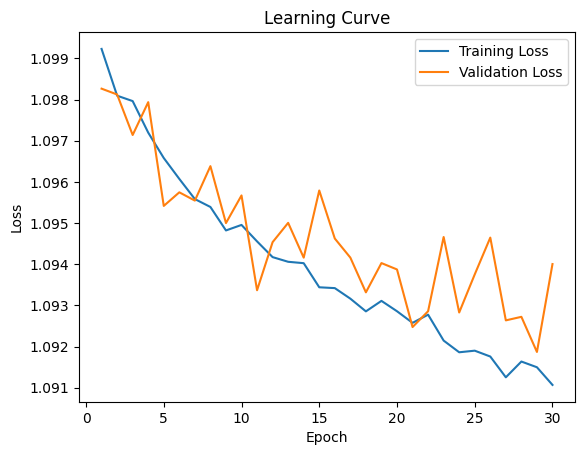

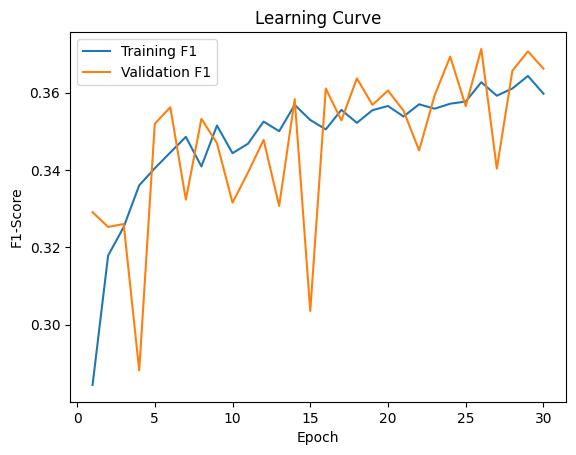

In [142]:
loss_fn = nn.CrossEntropyLoss()
best_f1 = 0 #initialize variables
best_loss = 0
best_accuracy = 0
learning_rate = 1e-4
patience = 0
epochs_count = 30
patience_tol = 10
f1_train_scores = []
f1_val_scores = []
train_losses = []
val_losses = []

model = FeedForwardNeuralNetwork(dropout_rate = 0.2).to(device) #Create a feedforward network instance

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
#scheduler1 = torch.optim.lr_scheduler.PolynomialLR(optimizer,verbose=True,power=3.0)
#scheduler1 = torch.optim.lr_scheduler.PolynomialLR(optimizer,verbose=True,power=3.0)
#scheduler2 = torch.optim.lr_scheduler.LinearLR(optimizer,verbose=True)
#scheduler = torch.optim.lr_scheduler.ChainedScheduler([scheduler1,scheduler2])

for t in range(epochs_count): #iterate over the number of epochs
    print(f"Epoch {t+1}\n-------------------------------")
    torch.cuda.synchronize()

    f1_train,train_loss = Train(Train_set,model,loss_fn,optimizer) #train the convo network
    print(f1_train.cpu())
    f1_train_scores.append(f1_train.cpu())
    train_losses.append(train_loss)
    f1_val,val_loss,accuracy,confusionMatrix = Validation(Validation_set,model,loss_fn) #find the current f1 score

    f1_val_scores.append(f1_val.cpu())
    val_losses.append(val_loss)

    #scheduler.step()

    if f1_val > best_f1: #if it the best one yet
        best_f1 = f1_val #set it as the best one
        best_loss = val_loss
        best_confmat = confusionMatrix
        best_accuracy = accuracy
        best_model = model #this is the best model yet
        patience = 0
    else:
        patience+=1 #else increment patience
    if patience == patience_tol: #if we have iterated over a number of epochs and still the model we found is the best one
        break #break from the iteration

print(f"Test Error: \n Accuracy: {(100*best_accuracy):>0.1f}%, Avg loss: {best_loss:>8f},Avg F1-Score: {best_f1:>8f}\n") #print statistics
print(f"Confusion Matrix \n: {best_confmat}\n") #print confusion matrix
plot_loss_learning_curve(train_losses=train_losses,val_losses=val_losses)
plot_f1_learning_curve(train_f1=f1_train_scores,val_f1=f1_val_scores)
#Test(Validation_set,best_model,loss_fn) #print the best model found

5 Epochs not enough,incrase number to 10,20,30

$
\begin{array}{|c|c|c|c|}
\hline
\text{Optimizer} & \text{Accuracy} & \text{F1-Score} & \text{Time}\\
\hline
\text{SGD} & \text{34.2\%} & \text{0.322498} & \text{1m13.1s}\\
\hline
\text{Adadelta} & \text{33.4\%} & \text{0.192038} & \text{1m19.8s}\\
\hline
\text{Adagrad} & \text{35.7\%} & \text{0.346080} & \text{1m23.0s}\\
\hline
\text{Adam} & \text{36.8\%} & \text{0.363755} & \text{1m15.4s}\\
\hline
\text{AdamW} & \text{36.4\%} & \text{0.361234} & \text{1m15.7s}\\
\hline
\text{Adamax} & \text{36.4\%} & \text{0.362846} & \text{1m28.2s}\\
\hline
\text{ASGD} & \text{33.5\%} & \text{0.305978} & \text{1m20.6s}\\
\hline
\end{array}
$

$
\begin{array}{|c|c|c|}
\hline
\text{Activator} & \text{Accuracy} & \text{F1-Score}\\
\hline
\text{ReLu} & \text{37.6\%} & \text{0.376192}\\
\hline
\text{ELU} & \text{37.0\%} & \text{0.368329}\\
\hline
\text{HardShrink} & \text{33.3\%} & \text{0.170781}\\
\hline
\text{HardSigmoid} & \text{35.7\%} & \text{0.356180}\\
\hline
\text{HardTanh} & \text{36.4\%} & \text{0.363904}\\
\hline
\end{array}
$

$
\begin{array}{|c|c|c|}
\hline
\text{Learning Rate} & \text{Accuracy} & \text{F1-Score}\\
\hline
\text{1e-2} & \text{33.4\%} & \text{0.171078}\\
\hline
\text{1e-3} & \text{37.8\%} & \text{0.369079}\\
\hline
\text{1e-4} & \text{37.3\%} & \text{0.371504}\\
\hline
\text{1e-5} & \text{36.7\%} & \text{0.363127}\\
\hline
\text{1e-6} & \text{33.7\%} & \text{0.237363}\\
\hline
\end{array}
$

$
\begin{array}{|c|c|c|}
\hline
\text{Dropout Rate} & \text{Accuracy} & \text{F1-Score}\\
\hline
\text{0} & \text{37.3\%} & \text{0.371504}\\
\hline
\text{0.2} & \text{37.4\%} & \text{0.373351}\\
\hline
\text{0.3} & \text{36.5\%} & \text{0.359243}\\
\hline
\text{0.5} & \text{36.6\%} & \text{0.358474}\\
\hline
\text{0.7} & \text{35.2\%} & \text{0.350322}\\
\hline
\end{array}
$

$
\begin{array}{|c|c|c|c|}
\hline
\text{Patience} & \text{Accuracy} & \text{F1-Score} & \text{Time}\\
\hline
\text{3} & \text{36.6\%} & \text{0.337105} & \text{24.0s}\\
\hline
\text{5} & \text{36.3\%} & \text{0.359731} & \text{36.1s}\\
\hline
\text{7} & \text{36.5\%} & \text{0.365683} & \text{36.3s}\\
\hline
\text{10} & \text{36.8\%} & \text{0.364671} & \text{1m11.8s}\\
\hline
\text{None} & \text{37.3\%} & \text{0.371776} & \text{1m27.4s}\\
\hline
\end{array}
$


$
\begin{array}{|c|c|c|}
\hline
\text{Weight Decay} & \text{Accuracy} & \text{F1-Score}\\
\hline
\text{0.5} & \text{33.2\%} & \text{0.178205}\\
\hline
\text{1e-2} & \text{33.5\%} & \text{0.243869}\\
\hline
\text{1e-3} & \text{35.9\%} & \text{0.359615}\\
\hline
\text{1e-4} & \text{36.0\%} & \text{0.358785}\\
\hline
\text{1e-5} & \text{37.1\%} & \text{0.363609}\\
\hline
\text{1e-6} & \text{36.7\%} & \text{0.367714}\\
\hline
\text{1e-7} & \text{37.2\%} & \text{0.371323}\\
\hline
\end{array}
$

$
\begin{array}{|c|c|c|}
\hline
\text{Scheduler} & \text{Accuracy} & \text{F1-Score}\\
\hline
\text{LinearLR} & \text{39.6\%} & \text{0.005854}\\
\hline
\text{PolynomialLR} & \text{39.8\%} & \text{0.005816}\\
\hline
\text{ExponentialLR} & \text{39.3\%} & \text{0.005736}\\
\hline
\text{CosineAnnealingLR} & \text{39.4\%} & \text{0.005846}\\
\hline
\text{LinearLR + PolynomialLR} & \text{39.4\%} & \text{0.005920}\\
\hline
\end{array}
$

$
\begin{array}{|c|c|c|c|}
\hline
\text{Batch Size} & \text{Accuracy} & \text{F1-Score} & \text{Time}\\
\hline
\text{1} & \text{39.1\%} & \text{0.390864} & \text{35m37.0s,DROPOUT = 0.7}\\
\hline
\text{1} & \text{39.1\%} & \text{0.391055} & \text{34m36.7s,DROPOUT = 0.5}\\
\hline
\text{1} & \text{39.4\%} & \text{0.393540} & \text{29m51.7s}\\
\hline
\text{2} & \text{39.5\%} & \text{0.194795} & \text{28m54.8s}\\
\hline
\text{4} & \text{38.8\%} & \text{0.097285} & \text{15m57.6s}\\
\hline
\text{8} & \text{39.5\%} & \text{0.048986} & \text{7m43.6s}\\
\hline
\text{16} & \text{39.0\%} & \text{0.024100} & \text{2m17.7s}\\
\hline
\text{32} & \text{39.5\%} & \text{0.012279} & \text{1m10.7s}\\
\hline
\text{64} & \text{39.6\%} & \text{0.005928} & \text{37.6s}\\
\hline
\text{128} & \text{39.2\%} & \text{0.003003} & \text{19.0s}\\
\hline
\end{array}
$

Final Training-Validation

In [ ]:
loss_fn = nn.CrossEntropyLoss()
best_f1 = 0 #initialize variables
learning_rate = 1e-4
patience = 0
epochs_count = 30
patience_tol = 10
f1_train_scores = []
f1_val_scores = []
train_losses = []
val_losses = []

optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate,weight_decay=1e-4)
scheduler1 = torch.optim.lr_scheduler.PolynomialLR(optimizer,verbose=True,power=3.0)
scheduler2 = torch.optim.lr_scheduler.LinearLR(optimizer,verbose=True)
scheduler = torch.optim.lr_scheduler.ChainedScheduler([scheduler1,scheduler2])

for t in range(epochs_count): #iterate over the number of epochs
    print(f"Epoch {t+1}\n-------------------------------")
    torch.cuda.synchronize()

    f1_train,train_loss = Train(Train_set,model,loss_fn,optimizer) #train the convo network

    f1_train_scores.append(f1_train.cpu())
    train_losses.append(train_loss)
    f1_val,val_loss = Validation(Validation_set,model,loss_fn) #find the current f1 score

    f1_val_scores.append(f1_val.cpu())
    val_losses.append(val_loss)

    scheduler.step()

    if f1_val > best_f1: #if it the best one yet
        best_f1 = f1_val #set it as the best one
        best_model = model #this is the best model yet
        patience = 0
    else:
        patience+=1 #else increment patience
    if patience == patience_tol: #if we have iterated over a number of epochs and still the model we found is the best one
        break #break from the iteration

print(f"Best Model computed by finding the model with the highest f1 score on the validation set: {best_f1:>8f}\n")
plot_loss_learning_curve(train_losses=train_losses,val_losses=val_losses)
plot_f1_learning_curve(train_f1=f1_train_scores,val_f1=f1_val_scores)
Test(Validation_set,best_model,loss_fn) #print the best model found

Predict Test Labels

In [62]:
Predictions = []

with torch.no_grad(): #disable gradient caclulation since we are testing not training
    for X in Test_set:
        X = X[0].to(device) #Load to GPU

        pred = model(X) #predict the label
        Predictions.append(pred.argmax(1).cpu())
        
Predictions = [pred.item() for pred in Predictions]

In [63]:
#Create a dataframe based on a dictionary of the IDs and the predictions
y_test = pd.DataFrame(data={'Id': test_set['New_ID'], 'Predicted': Predictions})

#Convert the predicted labels [0,1,2] back to their corresponding labels [NEGATIVE,NEUTRAL,POSITIVE]
y_test['Predicted'] = y_test['Predicted'].apply(lambda x: labels.get(x,x))

#Save as csv
y_test.to_csv('sumbission.csv',index=False)

Number of epochs not enough for model to learn,increase to 10,then 20 and then 30